In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

plt.style.use('ggplot')

In [ ]:
df=pd.read_csv('/content/tripadvisor_hotel_reviews.csv', engine='python')
print(df.shape)
df=df.head(1000)
print(df.shape)

(20491, 2)
(1000, 2)


In [ ]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


**Exploratory Data Analysis**

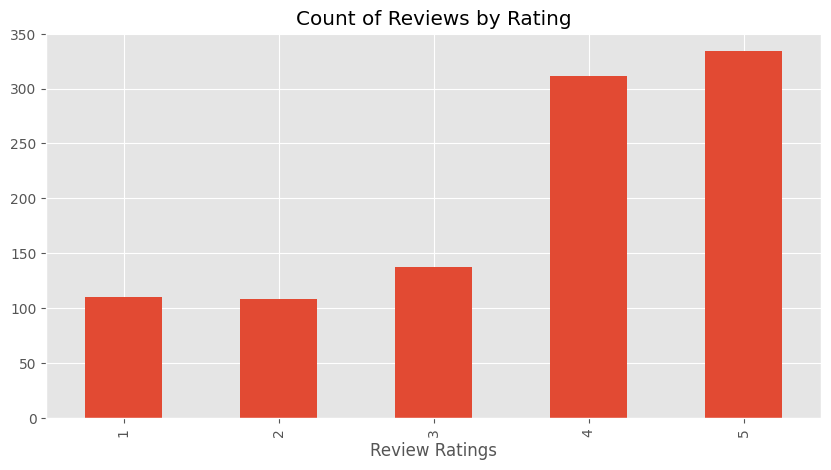

In [ ]:
ax = df['Rating'].value_counts().sort_index() \
     .plot(kind='bar',
           title='Count of Reviews by Rating',
           figsize=(10,5) )

ax.set_xlabel('Review Ratings')
plt.show()

**VADER**

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
sia.polarity_scores('I am delighted')

{'neg': 0.0, 'neu': 0.233, 'pos': 0.767, 'compound': 0.5106}

In [ ]:
sia.polarity_scores('I am upset')

{'neg': 0.722, 'neu': 0.278, 'pos': 0.0, 'compound': -0.3818}

In [ ]:
sia.polarity_scores(exp)

{'neg': 0.081, 'neu': 0.7, 'pos': 0.219, 'compound': 0.9889}

In [ ]:
df = df.rename_axis('Id').reset_index()

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Review']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print(res)

{0: {'neg': 0.072, 'neu': 0.643, 'pos': 0.285, 'compound': 0.9747}, 1: {'neg': 0.11, 'neu': 0.701, 'pos': 0.189, 'compound': 0.9787}, 2: {'neg': 0.081, 'neu': 0.7, 'pos': 0.219, 'compound': 0.9889}, 3: {'neg': 0.06, 'neu': 0.555, 'pos': 0.385, 'compound': 0.9912}, 4: {'neg': 0.135, 'neu': 0.643, 'pos': 0.221, 'compound': 0.9797}, 5: {'neg': 0.084, 'neu': 0.651, 'pos': 0.265, 'compound': 0.987}, 6: {'neg': 0.026, 'neu': 0.609, 'pos': 0.364, 'compound': 0.9925}, 7: {'neg': 0.032, 'neu': 0.74, 'pos': 0.228, 'compound': 0.959}, 8: {'neg': 0.038, 'neu': 0.663, 'pos': 0.298, 'compound': 0.9618}, 9: {'neg': 0.064, 'neu': 0.451, 'pos': 0.484, 'compound': 0.9756}, 10: {'neg': 0.08, 'neu': 0.524, 'pos': 0.395, 'compound': 0.9666}, 11: {'neg': 0.076, 'neu': 0.629, 'pos': 0.296, 'compound': 0.9242}, 12: {'neg': 0.075, 'neu': 0.551, 'pos': 0.374, 'compound': 0.9859}, 13: {'neg': 0.138, 'neu': 0.639, 'pos': 0.224, 'compound': 0.7584}, 14: {'neg': 0.051, 'neu': 0.467, 'pos': 0.482, 'compound': 0.9608

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [ ]:
vaders.head()

,Id,neg,neu,pos,compound,Review,Rating
0,0,0.072,0.643,0.285,0.9747,nice hotel expensive parking got good deal sta...,4
1,1,0.110,0.701,0.189,0.9787,ok nothing special charge diamond member hilto...,2
2,2,0.081,0.700,0.219,0.9889,nice rooms not 4* experience hotel monaco seat...,3
3,3,0.060,0.555,0.385,0.9912,"unique, great stay, wonderful time hotel monac...",5
4,4,0.135,0.643,0.221,0.9797,"great stay great stay, went seahawk game aweso...",5


**Plot VADER results**

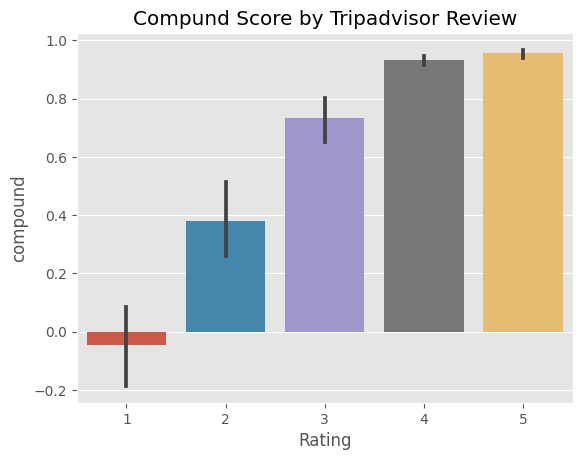

In [ ]:
ax = sns.barplot(data=vaders, x='Rating', y='compound')
ax.set_title('Compund Score by Tripadvisor Review')
plt.show()

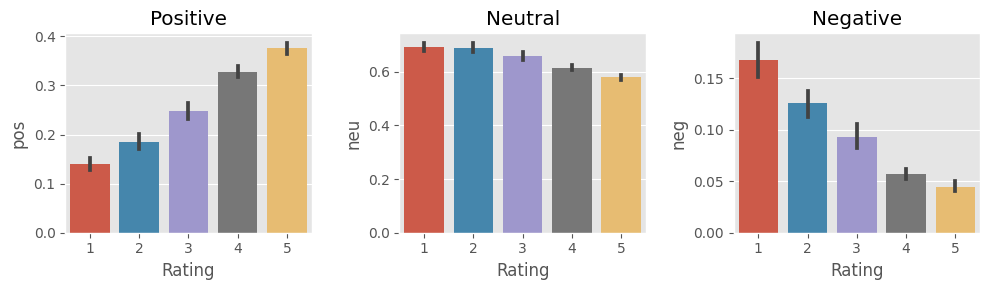

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
sns.barplot(data=vaders, x='Rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

**Roberta**

In [ ]:
!pip install transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def polarity_scores_roberta(exp):
    encoded_text = tokenizer(exp, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Review']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id 344
Broke for id 442
Broke for id 487


In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [ ]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Review,Rating
0,0,0.072,0.643,0.285,0.9747,0.019479,0.104080,0.876442,nice hotel expensive parking got good deal sta...,4
1,1,0.110,0.701,0.189,0.9787,0.587674,0.358500,0.053826,ok nothing special charge diamond member hilto...,2
2,2,0.081,0.700,0.219,0.9889,0.289251,0.548734,0.162015,nice rooms not 4* experience hotel monaco seat...,3
3,3,0.060,0.555,0.385,0.9912,0.003897,0.033762,0.962341,"unique, great stay, wonderful time hotel monac...",5
4,4,0.135,0.643,0.221,0.9797,0.073829,0.300111,0.626060,"great stay great stay, went seahawk game aweso...",5


**Comparison**

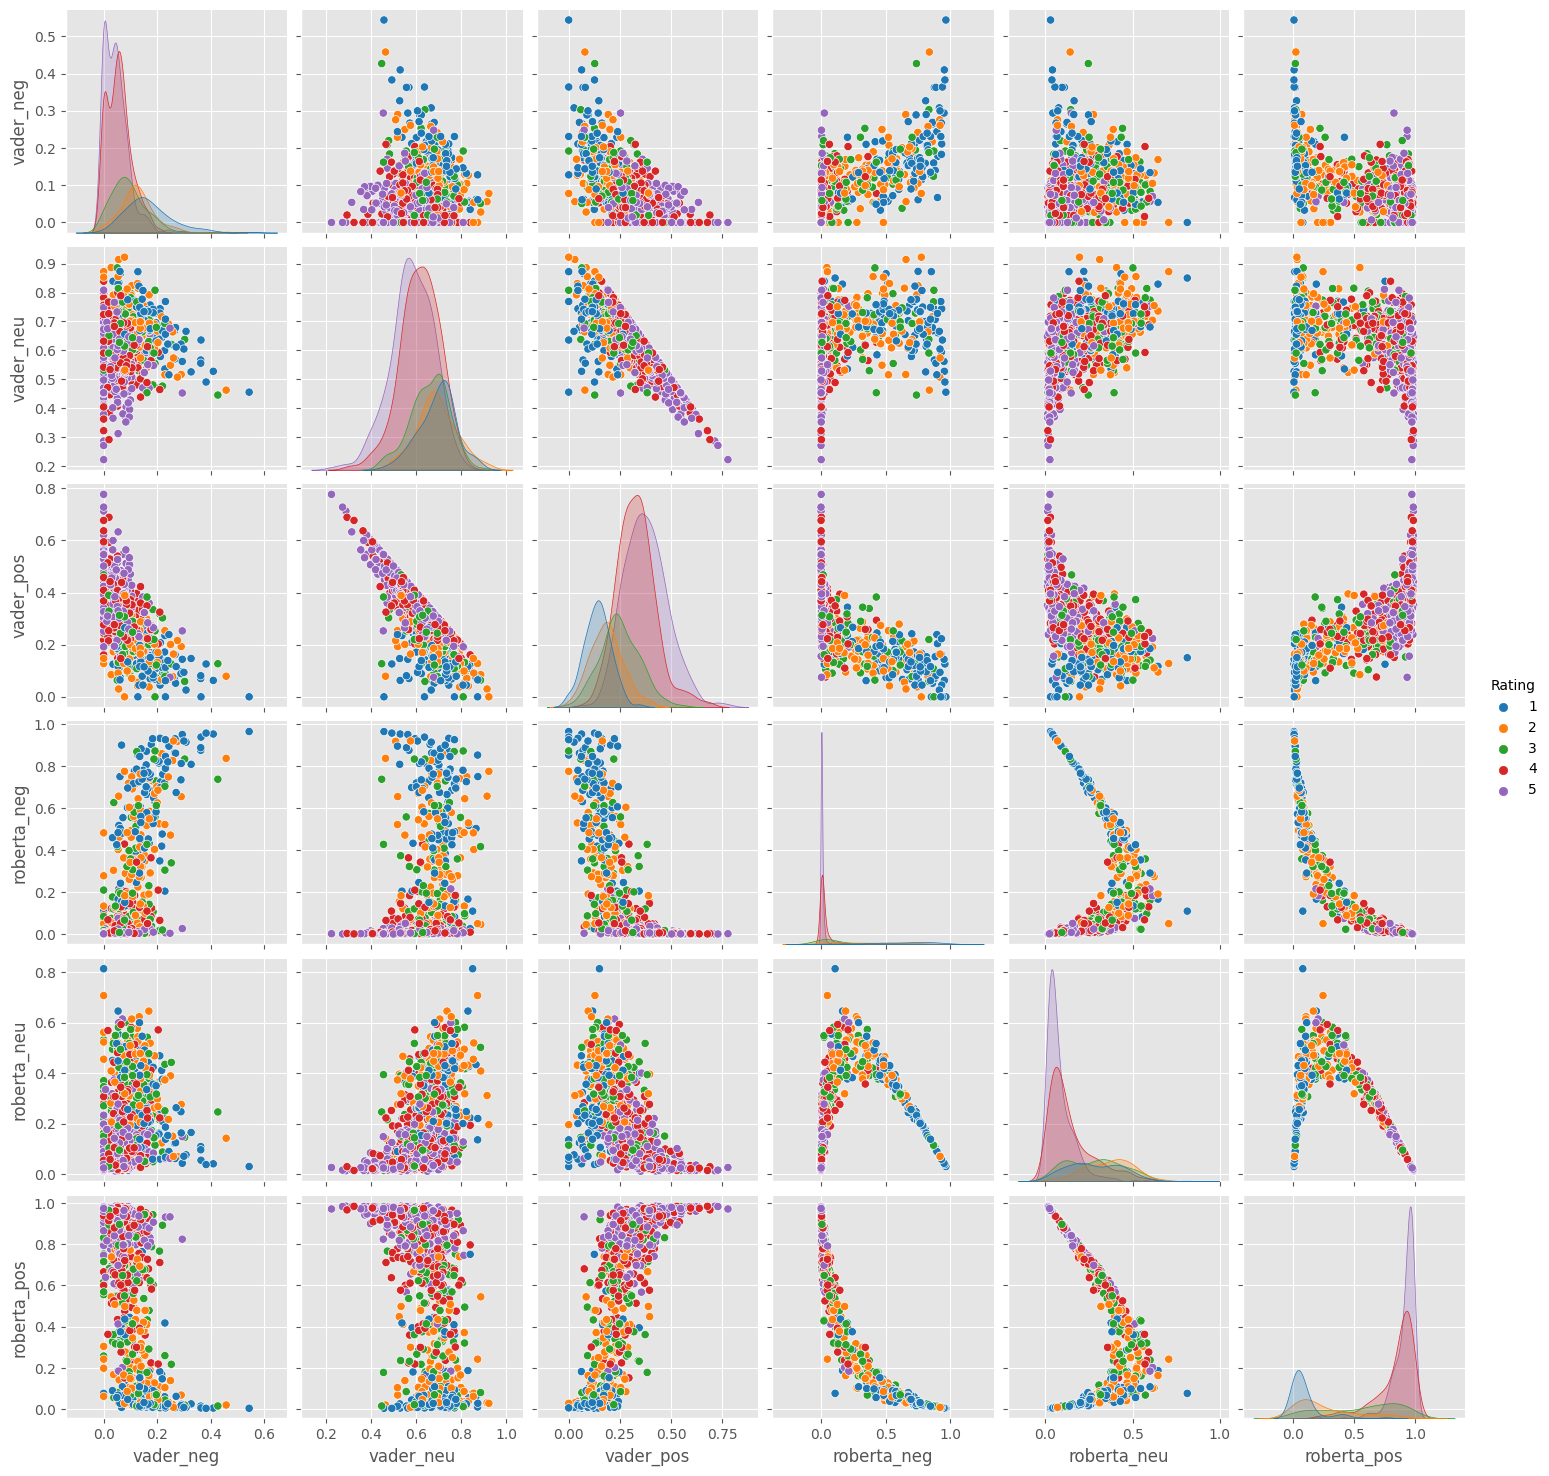

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg','vader_neu','vader_pos',
                   'roberta_neg','roberta_neu','roberta_pos'],
             hue='Rating',
             palette='tab10')
plt.show()

**Review Output**

**Positive rating but with high negative score**

In [ ]:
results_df.query('Rating == 5') \
    .sort_values('vader_neg', ascending=False)['Review'].values[0]

'simple perfect stayed times disappointed, rooms extremely spacious, location comfortable use car boston cambridge, nothing luxurious great value,  '

In [ ]:
results_df.query('Rating == 5') \
    .sort_values('roberta_neg', ascending=False)['Review'].values[0]

'light dark bali just got bali mandira great liked security, taxi enter hotel grounds guard came used rod sort torch mirror check beneath car bombs additional passengers.-cleanliness decor, choose modern room cottage, modern room lovely clean nice lighting ok beds nice bathroom, cottage rooms come chairs coffee table outside think modern rooms terrace balcony raised platform inside room, definite a.-food, did not opportunity order room service try parasol pizza parasol restaurant just remember tell waiter minus garlic comes huge chunks sprinkled pizza.-location, hotel located right beach walk beach leaving hotel grounds hotels like hard rock cross busy road, sunbeds facing beach bounds outsiders nice just watch bird not like view, none rooms ocean view waste, modern rooms look plain concrete verandah inaccessible, did not single mosquito bite stay saw mosquito 4 times 4 different mosquitoes, hotel staff did not replace shampoo bath foam tissue ran, sound trivial hygienic person not sur

**Negative rating but with high positive score**

In [ ]:
results_df.query('Rating == 1') \
    .sort_values('vader_pos', ascending=False)['Review'].values[0]

"stay plenty nice hotels seattle, not, terrible stay bellman lost luggage phones did n't work dirty sheets letter manager answered acknowledged, better staying,  "

In [ ]:
results_df.query('Rating == 1') \
    .sort_values('roberta_pos', ascending=False)['Review'].values[0]

'stay away dirty rooms stayed far better places seattle, room size prison cell window facing outside wall, quiet showered flushed toilet, plus seattle best coffee lobby right downtown, hotel limo expect pay 30 yellow cab, hotel staff helpful friendly,  '

**ChatGPT**

In [ ]:
!pip install openai
import openai
openai.api_key="replacethiswithyourownapikey"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.0 MB/s eta 0:00:00


In [ ]:
import json
def polarity_scores_chatgpt(exp):
  completion = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=[{"role": "user", "content": f"Perform sentiment analysis for the following sentence and show the confidence level in between 0 to 1 in 3 decimal places for negative, neutral and positive sentiment sequentially in lower case for the sentence without further information or explaination and return dictionary.  _{exp}"}],
      temperature=0
  )
  sentiment_analysis=(completion['choices'][0]['message']['content'])
  json_sentiment_analysis=json.loads(sentiment_analysis)
  return json_sentiment_analysis

**Positive rating but with high negative score**

**Vader and ChatGPT comparison**

In [ ]:
results_df.query('Rating == 5') \
    .sort_values('vader_neg', ascending=False)['Review'].values[0]

'simple perfect stayed times disappointed, rooms extremely spacious, location comfortable use car boston cambridge, nothing luxurious great value,  '

In [ ]:
completion=polarity_scores_chatgpt(results_df.query('Rating == 5') \
    .sort_values('vader_neg', ascending=False)['Review'].values[0])

In [ ]:
res_1=results_df.query('Rating == 5') \
    .sort_values('vader_neg', ascending=False)['vader_neg'].values[0]
res_2=results_df.query('Rating == 5') \
    .sort_values('vader_neg', ascending=False)['vader_neu'].values[0]
res_3=results_df.query('Rating == 5') \
    .sort_values('vader_neg', ascending=False)['vader_pos'].values[0]

print("Vader Negative: "+str(res_1))
print("Vader Neutral: "+str(res_2))
print("Vader Positive: "+str(res_3))

print("ChatGPT Negative: "+str(completion['negative']))
print("ChatGPT Neutral: "+str(completion['neutral']))
print("CHatGPT Positive: "+str(completion['positive']))


Vader Negative: 0.294
Vader Neutral: 0.453
Vader Positive: 0.253
ChatGPT Negative: 0.143
ChatGPT Neutral: 0.714
CHatGPT Positive: 0.143


**Roberta and ChatGPT comparison**

In [ ]:
results_df.query('Rating == 5') \
    .sort_values('roberta_neg', ascending=False)['Review'].values[0]

'light dark bali just got bali mandira great liked security, taxi enter hotel grounds guard came used rod sort torch mirror check beneath car bombs additional passengers.-cleanliness decor, choose modern room cottage, modern room lovely clean nice lighting ok beds nice bathroom, cottage rooms come chairs coffee table outside think modern rooms terrace balcony raised platform inside room, definite a.-food, did not opportunity order room service try parasol pizza parasol restaurant just remember tell waiter minus garlic comes huge chunks sprinkled pizza.-location, hotel located right beach walk beach leaving hotel grounds hotels like hard rock cross busy road, sunbeds facing beach bounds outsiders nice just watch bird not like view, none rooms ocean view waste, modern rooms look plain concrete verandah inaccessible, did not single mosquito bite stay saw mosquito 4 times 4 different mosquitoes, hotel staff did not replace shampoo bath foam tissue ran, sound trivial hygienic person not sur

In [ ]:
completion_2=polarity_scores_chatgpt(results_df.query('Rating == 5') \
    .sort_values('roberta_neg', ascending=False)['Review'].values[0])

In [ ]:
res_4=results_df.query('Rating == 5') \
    .sort_values('roberta_neg', ascending=False)['roberta_neg'].values[0]
res_5=results_df.query('Rating == 5') \
    .sort_values('roberta_neg', ascending=False)['roberta_neu'].values[0]
res_6=results_df.query('Rating == 5') \
    .sort_values('roberta_neg', ascending=False)['roberta_pos'].values[0]

print("Roberta Negative: "+str(res_4))
print("Roberta Neutral: "+str(res_5))
print("Roberta Positive: "+str(res_6))

print("ChatGPT Negative: "+str(completion_2['negative']))
print("ChatGPT Neutral: "+str(completion_2['neutral']))
print("CHatGPT Positive: "+str(completion_2['positive']))


Roberta Negative: 0.2160688042640686
Roberta Neutral: 0.5993174314498901
Roberta Positive: 0.18461371958255768
ChatGPT Negative: 0.286
ChatGPT Neutral: 0.571
CHatGPT Positive: 0.143


**Negative rating but with high positive score**

**Vader and ChatGPT comparison**

In [ ]:
results_df.query('Rating == 1') \
    .sort_values('vader_pos', ascending=False)['Review'].values[0]

"stay plenty nice hotels seattle, not, terrible stay bellman lost luggage phones did n't work dirty sheets letter manager answered acknowledged, better staying,  "

In [ ]:
completion_3=polarity_scores_chatgpt(results_df.query('Rating == 1') \
    .sort_values('vader_pos', ascending=False)['Review'].values[0])

In [ ]:
res_7=results_df.query('Rating == 1') \
    .sort_values('vader_pos', ascending=False)['vader_neg'].values[0]
res_8=results_df.query('Rating == 1') \
    .sort_values('vader_pos', ascending=False)['vader_neu'].values[0]
res_9=results_df.query('Rating == 1') \
    .sort_values('vader_pos', ascending=False)['vader_pos'].values[0]

print("Vader Negative: "+str(res_7))
print("Vader Neutral: "+str(res_8))
print("Vader Positive: "+str(res_9))

print("ChatGPT Negative: "+str(completion_3['negative']))
print("ChatGPT Neutral: "+str(completion_3['neutral']))
print("CHatGPT Positive: "+str(completion_3['positive']))


Vader Negative: 0.074
Vader Neutral: 0.581
Vader Positive: 0.344
ChatGPT Negative: 0.857
ChatGPT Neutral: 0.143
CHatGPT Positive: 0.0


**Roberta and ChatGPT comparison**

In [ ]:
results_df.query('Rating == 1') \
    .sort_values('roberta_pos', ascending=False)['Review'].values[0]

'stay away dirty rooms stayed far better places seattle, room size prison cell window facing outside wall, quiet showered flushed toilet, plus seattle best coffee lobby right downtown, hotel limo expect pay 30 yellow cab, hotel staff helpful friendly,  '

In [ ]:
completion_4=polarity_scores_chatgpt(results_df.query('Rating == 1') \
    .sort_values('roberta_pos', ascending=False)['Review'].values[0])

In [ ]:
res_10=results_df.query('Rating == 1') \
    .sort_values('roberta_pos', ascending=False)['roberta_neg'].values[0]
res_11=results_df.query('Rating == 1') \
    .sort_values('roberta_pos', ascending=False)['roberta_neu'].values[0]
res_12=results_df.query('Rating == 1') \
    .sort_values('roberta_pos', ascending=False)['roberta_pos'].values[0]

print("Roberta Negative: "+str(res_10))
print("Roberta Neutral: "+str(res_11))
print("Roberta Positive: "+str(res_12))

print("ChatGPT Negative: "+str(completion_4['negative']))
print("ChatGPT Neutral: "+str(completion_4['neutral']))
print("CHatGPT Positive: "+str(completion_4['positive']))



Roberta Negative: 0.022395286709070206
Roberta Neutral: 0.213276669383049
Roberta Positive: 0.7643280625343323
ChatGPT Negative: 0.667
ChatGPT Neutral: 0.333
CHatGPT Positive: 0.0
